In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample

In [3]:
data = pd.read_csv("bank_marketing.csv")

In [4]:
data['age_group'] = pd.cut(data['age'], bins=[17,25,35,50,65,100], 
                           labels=['18-25','26-35','36-50','51-65','65+'])
data['duration_bins'] = pd.cut(data['duration'], bins=5, labels=False)
data['balance_positive'] = (data['balance'] > 0).astype(int)
data['contact_known'] = (data['contact'] != 'unknown').astype(int)

In [5]:
data = pd.get_dummies(data, drop_first=True)

In [6]:
X = data.drop("y_yes", axis=1)
y = data["y_yes"]

In [16]:
X['target'] = y
majority = X[X['target'] == 0]
minority = X[X['target'] == 1]

majority_downsampled = resample(majority, replace=False,
                                n_samples=len(minority) * 2, 
                                random_state=42)
balanced_data = pd.concat([majority_downsampled, minority])

X = balanced_data.drop('target', axis=1)
y = balanced_data['target']

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
lr = LogisticRegression(max_iter=800, class_weight='balanced', random_state=42)
nn = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=200, random_state=42)

In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [11]:
rf_grid = {'n_estimators': [50, 100], 'max_depth': [10, 15]}
dt_grid = {'max_depth': [5, 10, 15]}
lr_grid = {'C': [0.1, 1]}
nn_grid = {
    'hidden_layer_sizes': [(32, 16), (64, 32)],
    'learning_rate_init': [0.001],
    'alpha': [0.0001]}

In [12]:
print("\nRunning 5-Fold Grid Search (optimized for runtime)...\n")

rf_search = GridSearchCV(rf, rf_grid, cv=cv, scoring='f1', n_jobs=-1)
rf_search.fit(X, y)

dt_search = GridSearchCV(dt, dt_grid, cv=cv, scoring='f1', n_jobs=-1)
dt_search.fit(X, y)

lr_search = GridSearchCV(lr, lr_grid, cv=cv, scoring='f1', n_jobs=-1)
lr_search.fit(X_scaled, y)

nn_search = GridSearchCV(nn, nn_grid, cv=cv, scoring='f1', n_jobs=-1)
nn_search.fit(X_scaled, y)



Running 5-Fold Grid Search (optimized for runtime)...



/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=MLPClassifier(hidden_layer_sizes=(64, 32),
                                     random_state=42),
             n_jobs=-1,
             param_grid={'alpha': [0.0001],
                         'hidden_layer_sizes': [(32, 16), (64, 32)],
                         'learning_rate_init': [0.001]},
             scoring='f1')

In [13]:
print("\nAverage F1 Scores (5-Fold CV):")
print(f"Random Forest:       {rf_search.best_score_:.2f} with {rf_search.best_params_}")
print(f"Decision Tree:       {dt_search.best_score_:.2f} with {dt_search.best_params_}")
print(f"Logistic Regression: {lr_search.best_score_:.2f} with {lr_search.best_params_}")
print(f"Neural Network:      {nn_search.best_score_:.2f} with {nn_search.best_params_}")



Average F1 Scores (5-Fold CV):
Random Forest:       0.82 with {'max_depth': 15, 'n_estimators': 100}
Decision Tree:       0.80 with {'max_depth': 10}
Logistic Regression: 0.81 with {'C': 1}
Neural Network:      0.78 with {'alpha': 0.0001, 'hidden_layer_sizes': (32, 16), 'learning_rate_init': 0.001}


In [14]:
best_rf = rf_search.best_estimator_
best_rf.fit(X, y)
importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)


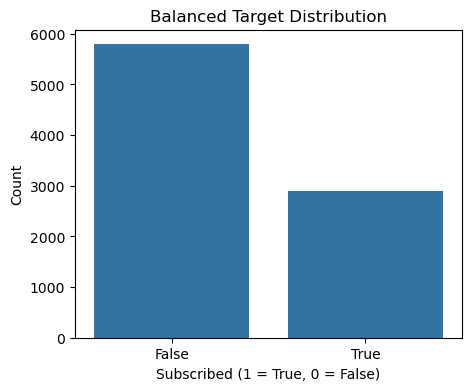

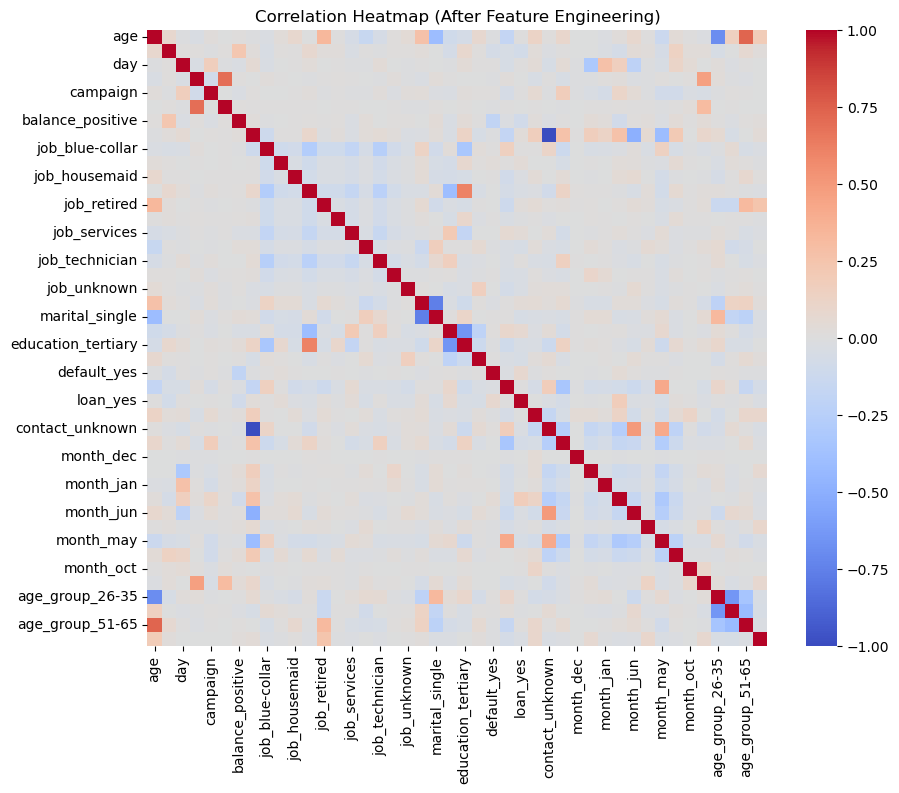

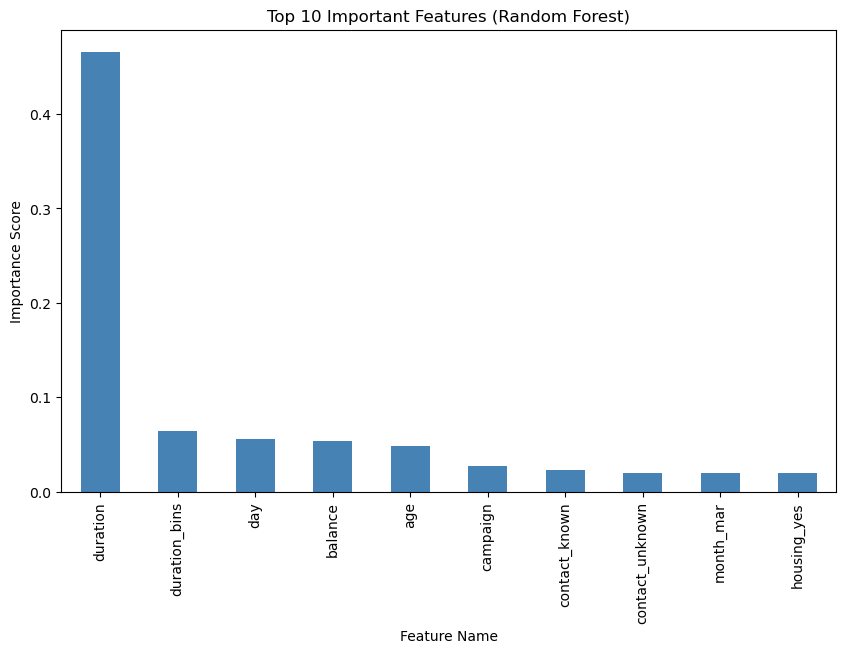

In [15]:

#Class distribution (after balancing)
plt.figure(figsize=(5,4))
sns.countplot(x=y)
plt.title("Balanced Target Distribution")
plt.xlabel("Subscribed (1 = True, 0 = False)")
plt.ylabel("Count")
plt.show()

#Correlation heatmap (after feature engineering)
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (After Feature Engineering)")
plt.show()

#Top feature importance from Random Forest
plt.figure(figsize=(10,6))
importances.head(10).plot(kind='bar', color='steelblue')
plt.title("Top 10 Important Features (Random Forest)")
plt.ylabel("Importance Score")
plt.xlabel("Feature Name")
plt.show()